In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model
π = np.pi

1. What is the rate of temperature increase in Cambridge?
2. Are temperatures increasing at a constant rate, or has the increase accelerated?
3. How do results compare across the whole of the UK?

In [3]:
# Retrieving the dataset
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/climate.csv'
climate = pandas.read_csv(url)

# Define two extra covariates
climate['t'] = climate.yyyy + (climate.mm-1)/12    # timestamp in years
climate['temp'] = (climate.tmin + climate.tmax)/2  # monthly avg temp
climate.head()

,yyyy,mm,tmax,tmin,af,rain,sun,status,station,lat,lng,height,temp,t
0,1941,1,NaN,NaN,---,74.7,---,NaN,Aberporth,52.139,-4.57,133,NaN,1941.000000
1,1941,2,NaN,NaN,---,69.1,---,NaN,Aberporth,52.139,-4.57,133,NaN,1941.083333
2,1941,3,NaN,NaN,---,76.2,---,NaN,Aberporth,52.139,-4.57,133,NaN,1941.166667
3,1941,4,NaN,NaN,---,33.7,---,NaN,Aberporth,52.139,-4.57,133,NaN,1941.250000
4,1941,5,NaN,NaN,---,51.3,---,NaN,Aberporth,52.139,-4.57,133,NaN,1941.333333


In [4]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38243 entries, 0 to 38242
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   yyyy     38243 non-null  int64  
 1   mm       38243 non-null  int64  
 2   tmax     37315 non-null  float64
 3   tmin     37341 non-null  float64
 4   af       38243 non-null  object 
 5   rain     38243 non-null  object 
 6   sun      38070 non-null  object 
 7   status   284 non-null    object 
 8   station  38243 non-null  object 
 9   lat      38243 non-null  float64
 10  lng      38243 non-null  float64
 11  height   38243 non-null  int64  
 12  temp     37287 non-null  float64
 13  t        38243 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 4.1+ MB


In [5]:
climate.describe()

,yyyy,mm,tmax,tmin,lat,lng,height,temp,t
count,38243.000000,38243.000000,37315.000000,37341.000000,38243.000000,38243.000000,38243.000000,37287.000000,38243.000000
mean,1969.757995,6.489109,12.759740,5.948116,53.952713,-2.734815,70.762466,9.354868,1970.215421
std,36.981348,3.449639,5.044777,4.067745,2.505090,2.217660,73.163308,4.489731,36.980556
min,1853.000000,1.000000,-0.900000,-8.600000,50.218000,-6.880000,3.000000,-4.650000,1853.000000
25%,1950.000000,3.000000,8.500000,2.700000,51.761000,-4.430000,15.000000,5.650000,1950.250000
50%,1977.000000,6.000000,12.400000,5.500000,53.381000,-2.584000,49.000000,8.950000,1977.083333
75%,1998.000000,9.000000,16.900000,9.500000,55.311000,-1.262000,102.000000,13.150000,1998.750000
max,2021.000000,12.000000,28.300000,17.000000,60.139000,1.727000,327.000000,22.450000,2021.583333


In [ ]:
# extract the climate info at cambridge
climate_cambridge = climate[climate['station'] == 'Cambridge']
climate_cambridge.head()

## 1. What is the rate of temperature increase in Cambridge?
- Using a linear model y = α + β1 * sin(2πt) + β2 * sin(2πt) + β3 * (t-1959), where β3 is the increase rate (degree per unit year from 1959 onwards)
- α = -41.117,(β1, β2, β3) = -1.084,-6.562,0.026, hence the increase rate is 0.026 degrees per unit year

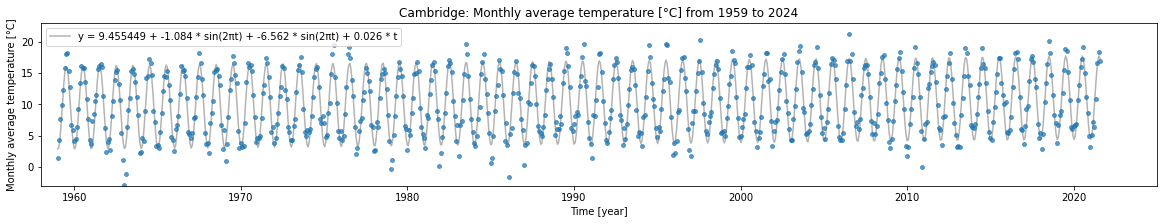

In [99]:
# a linear model y = α + β1 * sin(2πt) + β2 * sin(2πt) + β3 * t, where β3 is the increase rate (degree per unit year)

def overallRate(station):
  df = climate[(climate['station'] == station) & (climate['temp'].isna()==False)][['t','temp']]
  X = np.column_stack([np.sin(2*π*df.t), np.cos(2*π*df.t), (df.t-np.min(df.t))])
  model = sklearn.linear_model.LinearRegression()
  model.fit(X, df.temp)
  α,(β1,β2,β3) = (model.intercept_, model.coef_)

  # Plot a curve to depict the fitted values
  tnew = np.linspace(np.min(df.t), np.max(df.t), 1000)
  Xnew = np.column_stack([np.sin(2*π*tnew), np.cos(2*π*tnew), (tnew-np.min(df.t))])
  temp_pred = model.predict(Xnew)

  return α,β1,β2,β3,tnew, temp_pred

α,β1,β2,β3,tnew, temp_pred = overallRate('Cambridge')
fig,ax = plt.subplots(figsize=(20,3))
ax.scatter(climate_cambridge.t, climate_cambridge.temp, s=15, alpha=0.7)
ax.plot(tnew, temp_pred, color='0.7', zorder=0, label='y = {0:3f} + {1:.3f} * sin(2πt) + {2:.3f} * sin(2πt) + {3:.3f} * t'.format(α,β1,β2,β3))
ax.set_xlim([1958,2025])
ax.set_ylim([-3,23])
ax.set_xlabel("Time [year]")
ax.set_ylabel("Monthly average temperature [°C]")
ax.set_title('Cambridge: Monthly average temperature [°C] from 1959 to 2024')
ax.legend()
plt.show()

## 2. Are temperatures increasing at a constant rate, or has the increase accelerated?
- Split the timeline into three parts, each has 21 years: [1959 ~ 1979], [1980 ~ 2000], [2001 ~ 2021]
- Using linear model y =  α + β1 * sin(2πt) + β2 * sin(2πt) + β3 * (t-t_base) for each part
- results:
  * from year 1959 to year 1979, average incrase rate is -0.001 degrees per year
  * from year 1980 to year 2000, average incrase rate is 0.058 degrees per year
  * from year 2001 to year 2021, average incrase rate is 0.008 degrees per year

In [55]:
part1_time = climate_cambridge.t[climate_cambridge.t <= 1979]
part2_time = climate_cambridge.t[(climate_cambridge.t <= 2000) & (climate_cambridge.t >= 1980)]
part3_time = climate_cambridge.t[(climate_cambridge.t <= 2021) & (climate_cambridge.t >= 2001)]

part1_time_y = climate_cambridge.temp[climate_cambridge.t <= 1979]
part2_time_y = climate_cambridge.temp[(climate_cambridge.t <= 2000) & (climate_cambridge.t >= 1980)]
part3_time_y = climate_cambridge.temp[(climate_cambridge.t <= 2021) & (climate_cambridge.t >= 2001)]

data = [(part1_time, part1_time_y), (part2_time, part2_time_y), (part3_time, part3_time_y)]

from year 1959 to year 1979, average incrase rate is -0.001 degrees per year
from year 1980 to year 2000, average incrase rate is 0.058 degrees per year
from year 2001 to year 2021, average incrase rate is 0.008 degrees per year


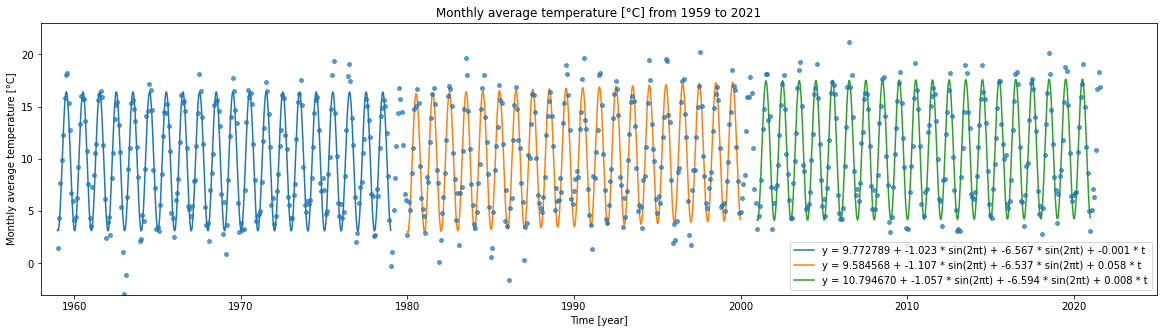

In [119]:
model = sklearn.linear_model.LinearRegression()
coef = []
pred = []
for x,y in data:
  X = np.column_stack([np.sin(2*π*x), np.cos(2*π*x), (x-np.min(x))])
  model.fit(X, y)
  α,(β1,β2,β3) = (model.intercept_, model.coef_)
  coef.append((α,β1,β2,β3))

  tnew = np.linspace(np.min(x), np.max(x), 1000)
  Xnew = np.column_stack([np.sin(2*π*tnew), np.cos(2*π*tnew), (tnew-np.min(x))])
  temp_pred = model.predict(Xnew)
  pred.append((tnew, temp_pred))

fig,ax = plt.subplots(figsize=(20,5))
ax.scatter(climate_cambridge.t, climate_cambridge.temp, s=15, alpha=0.7)

for i in range(3):
  α,β1,β2,β3 = coef[i]
  tnew, temp_pred = pred[i]
  print('from year {0:.0f} to year {1:.0f}, average incrase rate is {2:.3f} degrees per year'.format(np.min(tnew), np.max(tnew), β3))
  ax.plot(tnew, temp_pred, zorder=0, label='y = {0:3f} + {1:.3f} * sin(2πt) + {2:.3f} * sin(2πt) + {3:.3f} * t'.format(α,β1,β2,β3))

ax.legend()
ax.set_xlim([1958,2025])
ax.set_ylim([-3,23])
ax.set_xlabel("Time [year]")
ax.set_ylabel("Monthly average temperature [°C]")
ax.set_title('Monthly average temperature [°C] from 1959 to 2021')
plt.show()

## 3. How do results compare across the whole of the UK?

In [101]:
# find the set of stations in the data
unique_stations = np.unique(climate['station'])
unique_stations, len(unique_stations)

(array(['Aberporth', 'Armagh', 'Ballypatrick Forest', 'Bradford',
        'Braemar', 'Camborne', 'Cambridge', 'Cardiff Bute Park',
        'Chivenor', 'Cwmystwyth', 'Dunstaffnage', 'Durham', 'Eastbourne',
        'Eskdalemuir', 'Heathrow', 'Hurn', 'Lerwick', 'Leuchars',
        'Lowestoft', 'Manston', 'Nairn', 'Newton Rigg', 'Oxford',
        'Paisley', 'Ringway', 'Ross-On-Wye', 'Shawbury', 'Sheffield',
        'Southampton', 'Stornoway', 'Sutton Bonington', 'Tiree', 'Valley',
        'Waddington', 'Whitby', 'Wick Airport', 'Yeovilton'], dtype=object),
 37)

### Overall rate of change across the UK

In [86]:
def overallRate(station):
  df = climate[(climate['station'] == station) & (climate['temp'].isna()==False)][['t','temp']]
  X = np.column_stack([np.sin(2*π*df.t), np.cos(2*π*df.t), (df.t-np.min(df.t))])
  model = sklearn.linear_model.LinearRegression()
  model.fit(X, df.temp)
  α,(β1,β2,β3) = (model.intercept_, model.coef_)

  # Plot a curve to depict the fitted values
  tnew = np.linspace(np.min(df.t), np.max(df.t), 1000)
  Xnew = np.column_stack([np.sin(2*π*tnew), np.cos(2*π*tnew), (tnew-np.min(df.t))])
  temp_pred = model.predict(Xnew)

  return α,β1,β2,β3,tnew, temp_pred

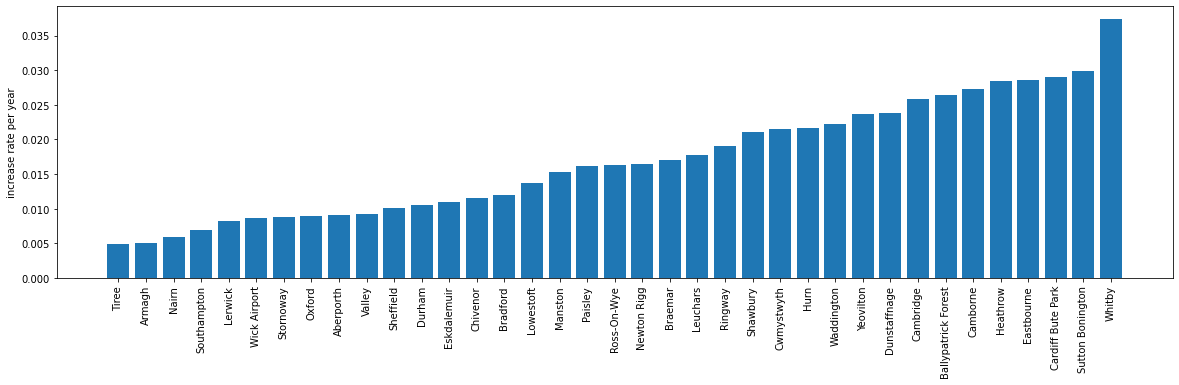

In [118]:
rate_set = []
for s in unique_stations:
  df = climate[(climate['station'] == s) & (climate['temp'].isna()==False)][['t','temp']]
  α,β1,β2,β3,tnew, temp_pred = overallRate(s)
  rate_set.append(β3)

fig,ax = plt.subplots(figsize=(20,5))
unique_stations = unique_stations[np.argsort(rate_set)]
rate_set = np.sort(rate_set)
ax.bar(unique_stations, rate_set)
ax.set_ylabel("increase rate per year")
plt.xticks(rotation = 90)
plt.show()